In [1]:
import os
os.getcwd()

'c:\\Users\\lenovo\\Desktop\\Python\\Final\\Sources'

In [2]:
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder

In [3]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)


def vgg_block(num_convs, in_channels, out_channels):
    blk = []
    for i in range(num_convs):
        if i == 0:
            blk.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1,bias=False))
        else:
            blk.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1,bias=False))
        blk.append(nn.ReLU())
    blk.append(nn.MaxPool2d(kernel_size=2, stride=2)) # 这里会使宽高减半
    return nn.Sequential(*blk)

def vgg(conv_arch, fc_features, fc_hidden_units):
    net = nn.Sequential()
    # 卷积层部分
    for i, (num_convs, in_channels, out_channels) in enumerate(conv_arch):
        # 每经过一个vgg_block都会使宽高减半
        net.add_module("vgg_block_" + str(i+1), vgg_block(num_convs, in_channels, out_channels))
    # 全连接层部分
    net.add_module("fc", nn.Sequential(
                                Reshape(),
                                nn.Linear(fc_features, fc_hidden_units),
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.Linear(fc_hidden_units, fc_hidden_units),
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.Linear(fc_hidden_units, 7)
                                ))
    return net

conv_arch = ((1, 1, 32), (1, 32, 64), (2, 64, 128))
# 经过5个vgg_block, 宽高会减半5次, 变成 224/32 = 7
fc_features = 128 * 6* 6 # c * w * h
fc_hidden_units = 1024 

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.data[index]

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.data)

In [5]:
# 修改数据预处理
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

In [6]:
# 加载FER2013数据集的CSV文件
data = pd.read_csv('fer2013.csv')

# 数据预处理和加载
train_data = []
test_data = []

for i in range(len(data)):
    emotion = data['emotion'][i]
    pixels = data['pixels'][i].split()
    image = Image.new('L', (48, 48))  # 创建灰度图像对象
    image.putdata([int(p) for p in pixels])  # 将像素值填充到图像中

    if data['Usage'][i] == 'Training':
        train_data.append((image, emotion))
    elif data['Usage'][i] == 'PublicTest':
        test_data.append((image, emotion))
    elif data['Usage'][i] == 'PrivateTest':
        test_data.append((image, emotion))

# 创建训练数据集和测试数据集
train_dataset = CustomDataset(train_data, transform=transform)
test_dataset = CustomDataset(test_data, transform=transform)

# 创建训练数据集和测试数据集的加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
learning_rate = 0.001
num_epochs = 5

In [8]:
model = vgg(conv_arch, fc_features, fc_hidden_units)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch [1/5], Train Loss: 1.7318, Train Accuracy: 0.2942, Test Loss: 1.4952, Test Accuracy: 0.4302
Epoch [2/5], Train Loss: 1.4316, Train Accuracy: 0.4469, Test Loss: 1.3054, Test Accuracy: 0.4990
Epoch [3/5], Train Loss: 1.2797, Train Accuracy: 0.5079, Test Loss: 1.2205, Test Accuracy: 0.5252
Epoch [4/5], Train Loss: 1.1775, Train Accuracy: 0.5510, Test Loss: 1.1973, Test Accuracy: 0.5458
Epoch [5/5], Train Loss: 1.0893, Train Accuracy: 0.5884, Test Loss: 1.1920, Test Accuracy: 0.5493
Finished Training


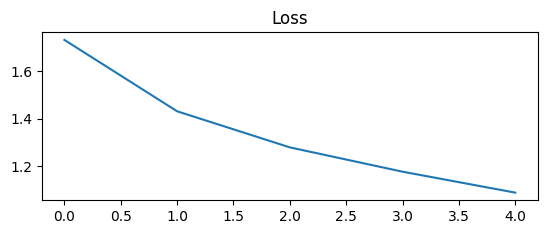

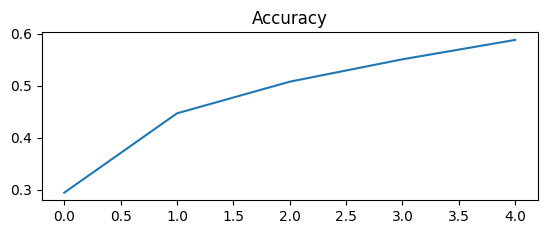

In [9]:
Loss = []
Accuracy = []
for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0.0
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        train_loss += loss.item() * inputs.size(0)

    train_loss = train_loss / len(train_dataset)
    train_accuracy = train_correct / len(train_dataset)
    Loss.append(train_loss)
    Accuracy.append(train_accuracy)

    model.eval()
    test_loss = 0.0
    test_correct = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            test_loss += loss.item() * inputs.size(0)

    test_loss = test_loss / len(test_dataset)
    test_accuracy = test_correct / len(test_dataset)

    print(
        f"Epoch [{epoch+1}/{num_epochs}], "
        f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
        f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}"
    )

print('Finished Training')
plt.subplot(2, 1, 1)
plt.plot(Loss)
plt.title('Loss')
plt.show()
plt.subplot(2, 1, 2)
plt.plot(Accuracy)
plt.title('Accuracy')
plt.show()

In [10]:
# 保存模型
torch.save(model.state_dict(), 'model_vgg.pth')